In [9]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.data import DataLoader
from torch_geometric.nn import HeteroConv, GCNConv, global_mean_pool
from torch_geometric.transforms import ToUndirected
import os, glob, json
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
GRAPH_FOLDER = "heterographs/"

In [10]:
# Load data
with open("data/labels.json") as f:
    labels_dict = json.load(f)

graphs, labels = [], []
for file in glob.glob(os.path.join(GRAPH_FOLDER, "*.pt")):
    graph = torch.load(file, weights_only=False)
    graph = ToUndirected()(graph)
    graph['label'] = torch.tensor([labels_dict[os.path.basename(file)]], dtype=torch.float)
    graphs.append(graph)
    labels.append(labels_dict[os.path.basename(file)])

train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, stratify=labels, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=2)

/Users/drew/Desktop/CS/CS 485/memecoin_fraud_detection/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
from torch_geometric.nn import SAGEConv

class RGCN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels=32):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x_dict, edge_index_dict, batch_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)

        pooled = []
        for ntype in x_dict:
            if ntype in batch_dict:
                pooled.append(global_mean_pool(x_dict[ntype], batch_dict[ntype]))

        if len(pooled) == 0:
            raise ValueError("No node types found for pooling in this batch.")

        x = torch.stack(pooled, dim=0).mean(dim=0)
        return self.lin(x).squeeze(-1)

In [12]:
# Training and testing
model = RGCN(train_graphs[0].metadata()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict, data.batch_dict)
        loss = criterion(out, data['label'].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = torch.sigmoid(model(data.x_dict, data.edge_index_dict, data.batch_dict))
            pred = (out > 0.5).float()
            all_preds.append(pred)
            all_labels.append(data['label'].float())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = (all_preds == all_labels).float().mean().item()

    # Avoid zero-division
    tp = ((all_preds == 1) & (all_labels == 1)).sum().item()
    fp = ((all_preds == 1) & (all_labels == 0)).sum().item()
    fn = ((all_preds == 0) & (all_labels == 1)).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1

# Train loop
df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy', 'precision', 'recall', 'f1'])
for epoch in range(1, 201):
    loss = train()
    accuracy, precision, recall, f1 = test(test_loader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Acc: {accuracy:.4f}, P: {precision:.4f}, R: {recall:.4f}, F1: {f1:.4f}")
    df = pd.concat([df, pd.DataFrame([{
        'epoch': epoch, 'loss': loss, 'accuracy': accuracy,
        'precision': precision, 'recall': recall, 'f1': f1
    }])], ignore_index=True)
    if loss < 0.01:
        break

df.to_csv("model/rgcn_training_results.csv", index=False)
torch.save(model.state_dict(), f"model/rgcn_epoch_{epoch}.pth")

/var/folders/j4/c8644dg12mz_qsqm39wfzlm00000gn/T/ipykernel_35643/2466731337.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


Epoch 10, Loss: 196.7287, Acc: 0.8333, P: 0.7500, R: 1.0000, F1: 0.8571
Epoch 20, Loss: 155.5783, Acc: 0.5000, P: 0.5000, R: 1.0000, F1: 0.6667
Epoch 30, Loss: 323.2695, Acc: 0.5000, P: 0.5000, R: 1.0000, F1: 0.6667
Epoch 40, Loss: 243.3722, Acc: 0.8333, P: 0.7500, R: 1.0000, F1: 0.8571
Epoch 50, Loss: 836.2630, Acc: 0.5000, P: 0.5000, R: 1.0000, F1: 0.6667
Epoch 60, Loss: 111.8388, Acc: 0.8333, P: 0.7500, R: 1.0000, F1: 0.8571
Epoch 70, Loss: 30.9612, Acc: 0.8333, P: 0.7500, R: 1.0000, F1: 0.8571
Epoch 80, Loss: 178.6538, Acc: 0.6667, P: 0.6000, R: 1.0000, F1: 0.7500
Epoch 90, Loss: 102.2481, Acc: 0.8333, P: 0.7500, R: 1.0000, F1: 0.8571
Epoch 100, Loss: 56.8781, Acc: 0.8333, P: 0.7500, R: 1.0000, F1: 0.8571
Epoch 110, Loss: 171.3770, Acc: 0.5000, P: 0.5000, R: 1.0000, F1: 0.6667
Epoch 120, Loss: 89.3230, Acc: 0.5000, P: 0.5000, R: 1.0000, F1: 0.6667
Epoch 130, Loss: 151.7818, Acc: 0.8333, P: 1.0000, R: 0.6667, F1: 0.8000
Epoch 140, Loss: 121.5009, Acc: 0.8333, P: 0.7500, R: 1.0000, F

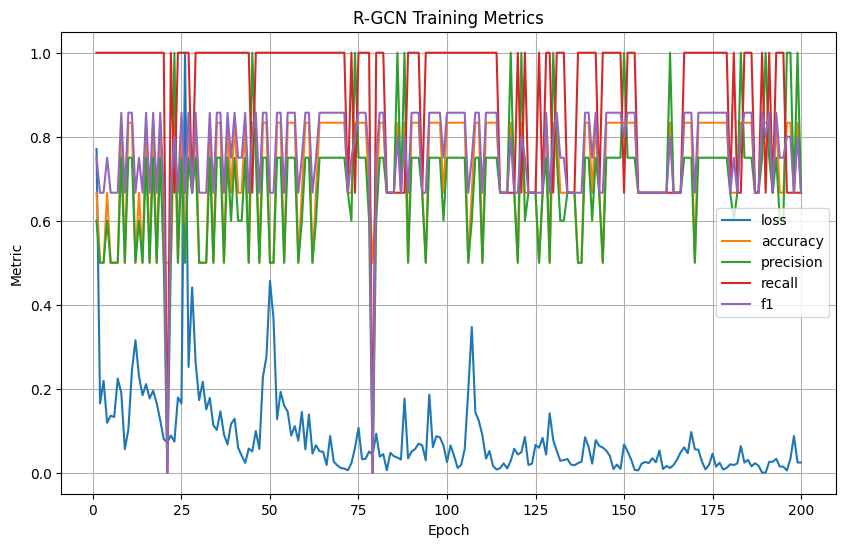

In [13]:
# Plot
df['loss'] = (df['loss'] - df['loss'].min()) / (df['loss'].max() - df['loss'].min())
plt.figure(figsize=(10, 6))
for col in ['loss', 'accuracy', 'precision', 'recall', 'f1']:
    plt.plot(df['epoch'], df[col], label=col)
plt.xlabel('Epoch'); plt.ylabel('Metric'); plt.title('R-GCN Training Metrics'); plt.legend(); plt.grid(True); plt.show()
